<a href="https://colab.research.google.com/github/sheshank1436/pytorch/blob/master/pytorch_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import tarfile
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import os
from torch.utils.data import random_split
from torchvision.utils import make_grid


In [2]:
project_name='05b-cifar10-resnet'

In [3]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'labels.txt', 'train']
['horse', 'bird', 'deer', 'frog', 'automobile', 'dog', 'airplane', 'cat', 'ship', 'truck']


# There are a few important changes we'll make while creating the PyTorch datasets:

1.Use test set for validation: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

2.Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3.Randomized data augmentations: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.


In [4]:
# Data transforms (normalization & data augmentation)
#values in the first paranthesis are means and second paranthesis are standard deviation
#we used torchvision.transforms to perform data augmentation and normalization
#inplace=True means instead of copying the tensors it will modify the tensors
#what reflect padding does is it will create a reflection of pixels close to it
#random crop will randomly crop the image
#here pics are also flipped in dataaugmentation
#we wil only perform data augmentation on training set
#we have many techniques in data augmentation we only used crop and horizontalflip
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [5]:
# PyTorch datasets
#The image datasets contains different classes of images in different folders 
#To handle such kinds of folders we used ImageFolder
#Here we use Test set as the validation set
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 400 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [6]:
batch_size = 400

In [7]:
# PyTorch data loaders
#num_workers and pin_memory are related to perfomance optimizers using GPU
#we wont split the val data because we need to compare the accuracy for the same data

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
#now lets look at the images in the form of a grid
#here we only display first 64 images in 8 rows
#permute keeps the channels in the lastdim as matplotlib requires in that way to plot
def show(dl):
  for images,labels in dl:
    fig,ax=plt.subplots(figsize=(12,12))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


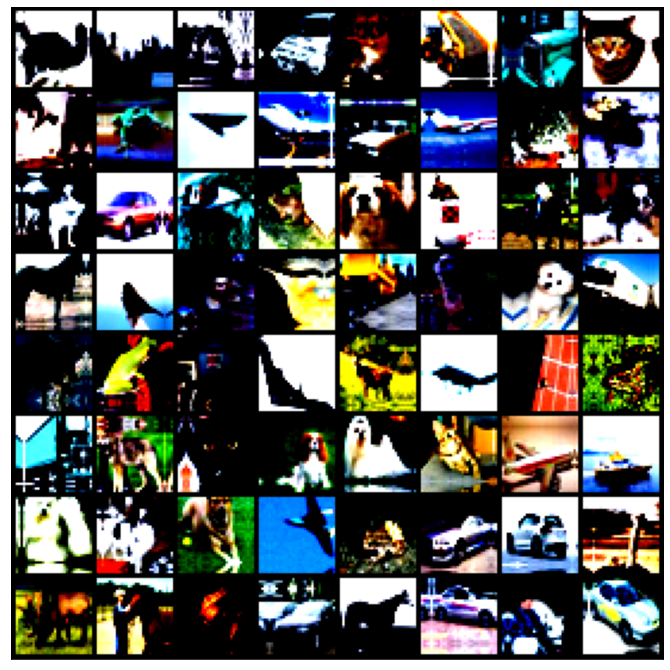

In [9]:
#the colors are so different because we applied normalization 
#these colors now range from -1 to 1
#red blue and green are centered at 0
#because of that colors seem to be slightly shifted and slightly sharper
#this makes the model easier to train and any changes to the pic can be easily understood by the model

show(train_dl)

## Using a **GPU**

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. 

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## **Model with Residual Blocks and Batch Normalization**

https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

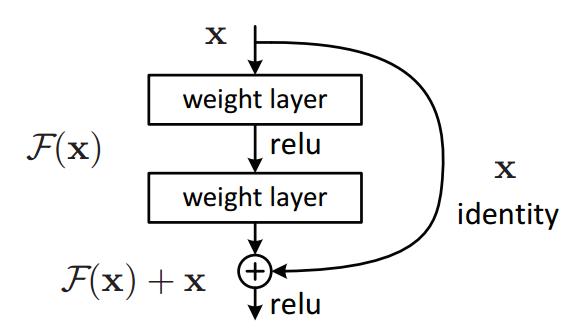

In [13]:
#this is a simple and small residual network
#here we cannot change the number of channels because we cannot perform addition if we change the no. of channels
#this resnet helps in improving the perfomance of the model
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1=nn.ReLU()
    self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()
  def forward(self,x):
    out=self.conv1(x)
    out=self.relu1(out)
    out=self.conv2(out)
    out=self.relu2(out)
    return out+x  

In [14]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


Batch normalization and dropout explained: 

 https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

After a particular layer some of the outputs might become to large and some of the outputs might become too small. In the below image lets say in first hidden layer there are 3 nodes. output of one node might be 100 then output of another might be less than 1. THis kind of things will effect the layers dis-proportionatly. what Batch normalization does is it will take the output of a layer and will apply normalization there.
First we normalise the inputs and then we normalize the outputs of the hidden layers.

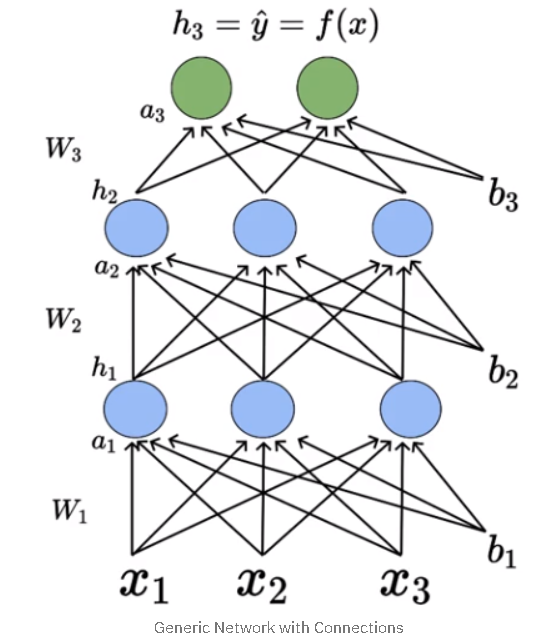

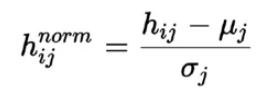

## We will use the ResNet9 architecture,


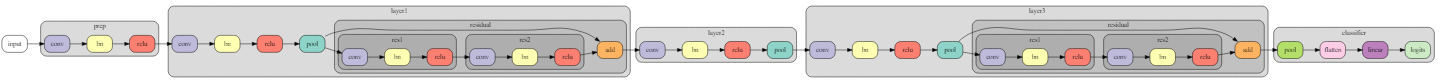

In [15]:
#in the below accuracy function preds torch.max will give max probability value from softmax as output and the index of max probability
#preds is the index for the max probability value
#dim=1 because we apply softmax to image
#dim=0 represents batch size
#here we are not going to keep learning rate as constant
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(labels==preds).item())

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


In [16]:
#inplace=True just makes negative values to zero
#here by default we have taken pool=False and if we want pooling then we will mention True while calling the function.
#we defined in this way because when we create residual network we keep pool as false because no of channels must match 
def convolution_block(in_channels,out_channels,pool=False):
  layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)]
  if pool:layers.append(nn.MaxPool2d(2)) 
  return nn.Sequential(*layers)        

In [17]:
#calling the function with pooling
convolution_block(3,32,True)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [18]:
#calling the function without using pooling
convolution_block(3,32)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [19]:
#we will design the network as per the pic above
#cross entropy does softmax internally
#xb is the inputs in batches
class ResNet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1=convolution_block(in_channels,64)    #64 x32 x32
    self.conv2=convolution_block(64,128,pool=True)   #128 x16 x16
    self.res1=nn.Sequential(convolution_block(128,128),convolution_block(128,128))  #128 x16 x16

    self.conv3=convolution_block(128,256,True)  #256 x8 x8
    self.conv4=convolution_block(256,512,True)  #512 x4 x4
    self.res2=nn.Sequential(convolution_block(512,512),convolution_block(512,512))  #512 x4 x4

    self.classifier=nn.Sequential(nn.MaxPool2d(4),  #512 x1 x1
                                  nn.Flatten(), #512
                                  nn.Linear(512,num_classes)) #10
  def forward(self,xb):
    out=self.conv1(xb)
    out=self.conv2(out)
    out=self.res1(out)+out
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.res2(out)+out
    out=self.classifier(out) 
    return out 



In [20]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## **Training the model**

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

Learning rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 


Learn more: https://sgugger.github.io/the-1cycle-policy.html

Weight decay: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

Gradient clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.




 Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

In [21]:
#we use no_grad for not to track the gradients
#evaluate function calculates the loss and accuracy for each batch and gives us the output loss and accuracy by averaging them.
#get_lr gets the learning rate from the optimizer and returns it.
#fit_one_cycle takes all the inputs where max_lr is the max value the learning rate should change to, weight decay is how much weightage u want to give to the weights
#grad_clip is whenever gradients are calculated they can be limited between certain values
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.07413461059331894, 'val_loss': 2.3049278259277344}]

In [23]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.2672, val_loss: 2.0147, val_acc: 0.4609
Epoch [1], last_lr: 0.00935, train_loss: 1.0018, val_loss: 1.1269, val_acc: 0.6532
Epoch [2], last_lr: 0.00972, train_loss: 0.8194, val_loss: 0.8096, val_acc: 0.7273
Epoch [3], last_lr: 0.00812, train_loss: 0.6098, val_loss: 0.5975, val_acc: 0.7985
Epoch [4], last_lr: 0.00556, train_loss: 0.4631, val_loss: 0.4483, val_acc: 0.8475
Epoch [5], last_lr: 0.00283, train_loss: 0.3547, val_loss: 0.4070, val_acc: 0.8560
Epoch [6], last_lr: 0.00077, train_loss: 0.2522, val_loss: 0.2980, val_acc: 0.8937
Epoch [7], last_lr: 0.00000, train_loss: 0.1879, val_loss: 0.2779, val_acc: 0.9050
CPU times: user 7min 38s, sys: 6min 7s, total: 13min 45s
Wall time: 14min 35s


In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

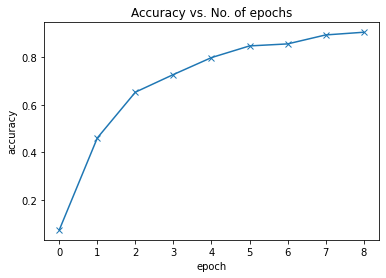

In [27]:
plot_accuracies(history)

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

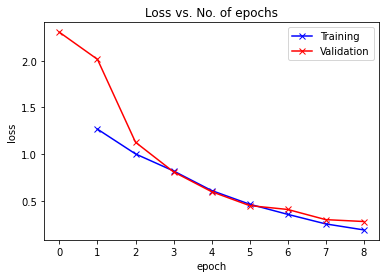

In [29]:
plot_losses(history)

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

The learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, 
and then gradually decreases to a very small value.

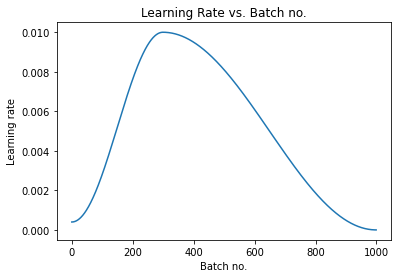

In [31]:

plot_lrs(history)